# Determining ideal tracking rate for Feder Observatory 

This notebook attempts to determine the "ideal" tracking rate by measuring drift in images over an extended period of time. 

Unfortunately, subimages used for measuring drift need to be large-ish or the readouts from the camera are bad.

## Data format from MaxImDL

The auto-guide tab in MaxImDL tracks a bright star in an image, with exposure length, exposure interval and more settable by the user. You can output the data from those runs in files with extension `.log`. These are really CSV files:

```
Track Log Started at UT 2018-01-06 02:45:07
Calibration Speed X, Y, Angle: 56.568542, 80.000000, 0.000000
UT Time,   Star X,  Star Y, OffsetX, OffsetY,  Corr X,  Corr Y,  Bright
02:45:07,  122.19,  101.83,    0.19,   -0.17,    0.10,   -0.13,    1001
02:45:09,  120.49,  103.52,   -1.51,    1.52,   -0.85,    1.21,    1009
02:45:11,  122.06,  101.81,    0.06,   -0.19,    0.03,   -0.14,    1013
02:45:13,  122.11,  101.77,    0.11,   -0.23,    0.06,   -0.18,    1012
02:45:15,  121.54,  102.56,   -0.46,    0.56,   -0.25,    0.44,    1012
02:45:17,  122.48,  102.89,    0.48,    0.89,    0.27,    0.71,    1011
...
```

(Note that in this particular example the "Bright" column is junk (which implies the others are too) because the camera reads out incorrect values in smallish subframes).

We ought to be able to read these in with astropy Table...

In [2]:
from astropy.table import Table, Column 
from astropy.time import Time
from astropy.nddata import CCDData
from astropy import units as u
%matplotlib notebook 

import matplotlib.pyplot as plt
import numpy as np

## Tracking file names and rates

The tracking files are keys in the dictionary below, with values being the RA tracking rate.

In [2]:
tracking_file_base_name = r'./tracking_log{}.log'
tracking_files = {
    1: 15.04,
    2: 15.06,
    3: 15.055,
    4: 15.05
}

In [3]:
def get_start_date(f):
    # get the UT date/time of start of log
    with open(f) as file:
        line1 = file.readline()
    _, rest = line1.split('Track Log Started at UT ')
    date, time = rest.split(' ')
    return date

In [4]:
drift_tables = {}
for f in sorted(tracking_files.keys()):
    fname = tracking_file_base_name.format(f)
    print(fname)
    drift1 = Table.read(fname, format='ascii', comment='(Track Log|Calibration).*', delimiter=',')
    ut_date = get_start_date(fname)
    # Make a real time column, in seconds since first time
    t0 = Time(ut_date + ' ' + drift1['UT Time'][0], scale='utc')
    elapsed_sec = [(Time(ut_date + ' ' + t, scale='utc') - t0).sec for t in drift1['UT Time']]
    theta = 21.115459206 / 180 * np.pi
    Dec_offset = np.cos(theta) * drift1['OffsetX'] + np.sin(theta) * drift1['OffsetY']
    RA_offset = np.sin(theta) * drift1['OffsetX'] - np.cos(theta) * drift1['OffsetY']
    drift1.add_column(Column(data=elapsed_sec, name='Seconds'))
    drift1.add_column(Column(data=RA_offset, name='OffsetRA'))
    drift1.add_column(Column(data=Dec_offset, name='OffsetDec'))
    r_drift = np.sqrt(drift1['OffsetX']**2 + drift1['OffsetY']**2)
    drift1.add_column(Column(data=r_drift, name='OffsetR'))
    drift_tables[f] = drift1

./tracking_log1.log


FileNotFoundError: [Errno 2] No such file or directory: './tracking_log1.log'

In [5]:
drift1['UT Time'] == 'UT Time'

NameError: name 'drift1' is not defined

In [7]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

<IPython.core.display.Javascript object>


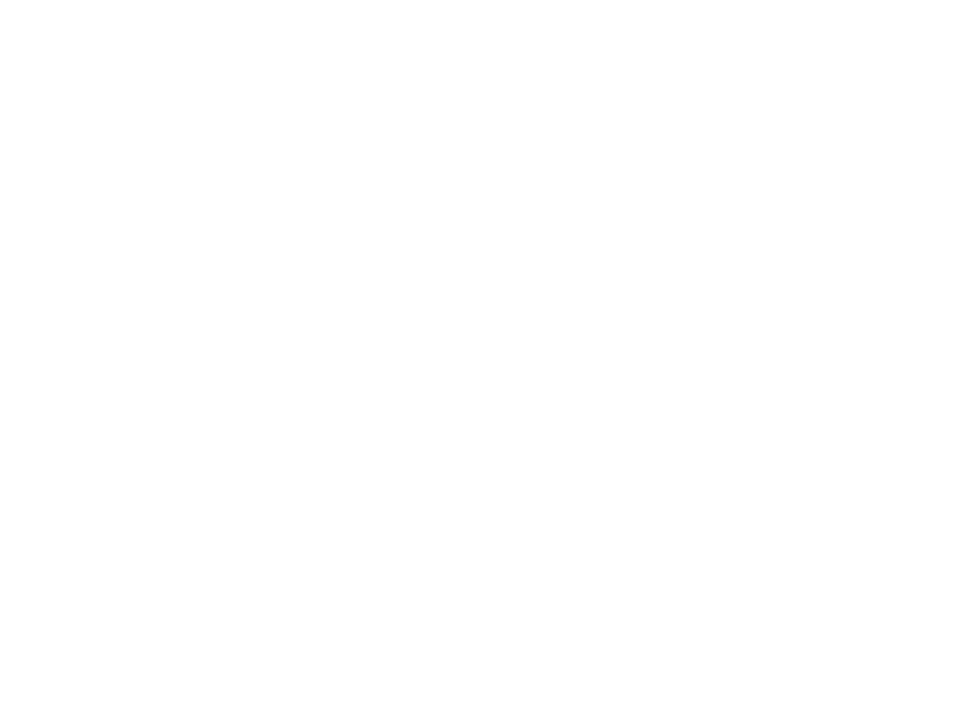

KeyError: 1

In [8]:
plt.figure()
i = 0
rates = []
lines = []
for f in sorted(tracking_files.keys()):
    color = i % len(colors)
    i += 1
    tab = drift_tables[f]
    rate = tracking_files[f]
    alpha = 1 - np.abs((rate - 15.05)/0.06)
#     plt.plot(tab['Seconds'], 
#              tab['OffsetX'], 
#              label='_X, rate: {}'.format(rate),
#              linestyle='dashed',
#              color=colors[color],
#              alpha=alpha
#             )
    plt.plot(tab['Seconds'], 
             tab['OffsetY'], 
             label='_Y, rate: {}'.format(rate),
             linestyle='dotted',
             color=colors[color],
             alpha=alpha
            )
    l = plt.plot(tab['Seconds'], 
             tab['OffsetR'], 
             label='R, rate: {}'.format(rate),
             linestyle='solid',
             color=colors[color],
             alpha=alpha)
    rates.append(rate)
    lines.append(l)
plt.xlabel('Seconds since start of tracking')
plt.ylabel('Displacement of centroid from start (pixels)')
plt.grid()
rates = np.array(rates)
#lines = np.array(lines)
s = np.argsort(rates)
rate_words = ['R, rate: {}'.format(r) for r in rates[s]]
lines = [lines[i][0] for i in s]
plt.legend(lines, rate_words, ncol=3)

## Tranform to RA/Dec drifts

Celestial north makes an angle of roughly $21.12^\circ$ with respect to the $x$-axis of the image; call that angle $\theta$. Then the displacement in RA and Dec (given the displacement in $x$ and $y$ in the image) are:

$$
\Delta \text{Dec} = \cos\theta \Delta x + \sin\theta \Delta y\\
\Delta \text{RA} = \sin\theta \Delta x - \cos\theta \Delta y
$$

<IPython.core.display.Javascript object>


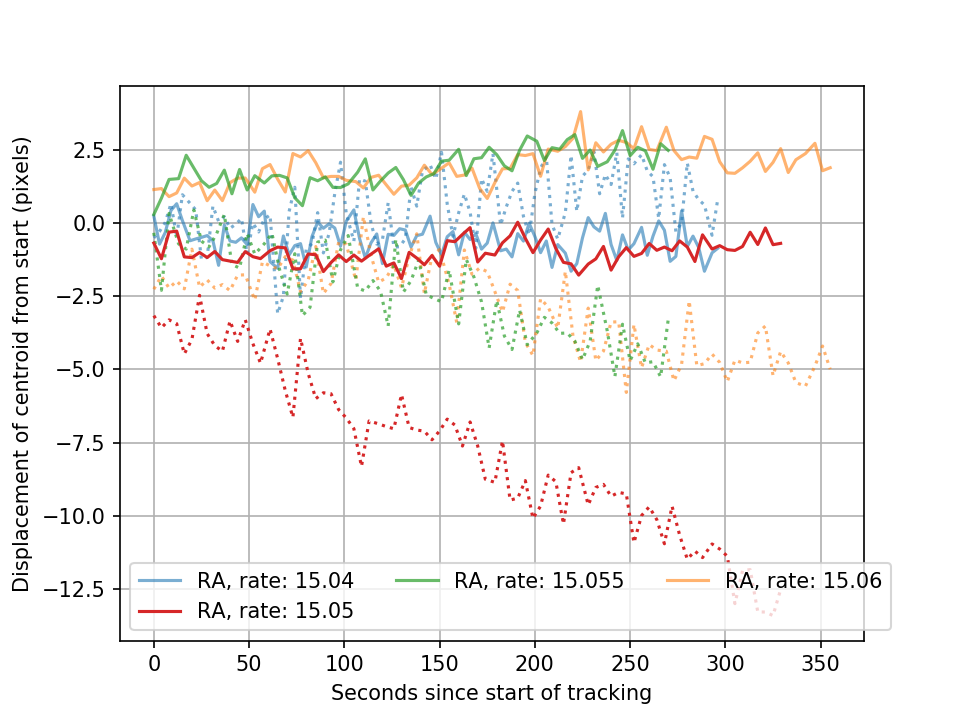

In [33]:
plt.figure()
i = 0
rates = []
lines = []
for f in sorted(tracking_files.keys()):
    color = i % len(colors)
    i += 1
    tab = drift_tables[f]
    rate = tracking_files[f]
    alpha = 1 - np.abs((rate - 15.05)/0.06)**0.5

    l = plt.plot(tab['Seconds'], 
             tab['OffsetRA'], 
             label='_Y, rate: {}'.format(rate),
             linestyle='solid',
             color=colors[color],
             alpha=alpha
            )
    plt.plot(tab['Seconds'], 
             tab['OffsetDec'], 
             label='_R, rate: {}'.format(rate),
             linestyle='dotted',
             color=colors[color],
             alpha=alpha)
    rates.append(rate)
    lines.append(l)
plt.xlabel('Seconds since start of tracking')
plt.ylabel('Displacement of centroid from start (pixels)')
plt.grid()
rates = np.array(rates)
#lines = np.array(lines)
s = np.argsort(rates)
rate_words = ['RA, rate: {}'.format(r) for r in rates[s]]
lines = [lines[i][0] for i in s]
plt.legend(lines, rate_words, ncol=3)



## Difference in WCS between two images ~15 min(?) apart


In [3]:
image1 = CCDData.read('./CoRoT-2b-0055r30.fit', unit='adu')
image2 = CCDData.read('./CoRoT-2b-0001r30.fit', unit='adu')

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [4]:
center_offset = (image1.wcs.wcs.crval - image2.wcs.wcs.crval) * u.degree

In [5]:
center_offset.to('arcsec')

<Quantity [-10.2876192 ,  25.24452772] arcsec>

In [6]:
(Time(image2.header['DATE-OBS']) - Time(image1.header['DATE-OBS'])).sec

-2714.000000000001